# Predicting Price with Size, Location and Neighbourhood

In [5]:
import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [42]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    #drop columns with more than half null values
    df.drop(columns = ["floor", "expenses"], inplace = True)

    #Dropping Low and High Cardinality categorical features
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)

    #Drop Leaky columns
    df.drop(columns = ["price", "price_aprox_local_currency","price_per_m2", "price_usd_per_m2"], inplace = True)

    # Drop columns with multicollinearity
    df.drop(columns = ["surface_total_in_m2", "rooms"], inplace = True)
   
    return df

In [43]:
# Collect files
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data\\buenos-aires-real-estate-1.csv',
 'data\\buenos-aires-real-estate-2.csv',
 'data\\buenos-aires-real-estate-3.csv',
 'data\\buenos-aires-real-estate-4.csv',
 'data\\buenos-aires-real-estate-5.csv']

In [44]:
# Wrangle with list comprehension
frames = [wrangle(file) for file in files]
type(frames)

list

In [45]:
#Combine data into a single data frame
df = pd.concat(frames,ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


## Explore

In [18]:
#identify and drop null values
df.isnull().head()
#drop columns with more than half null values
df.isnull().sum()/len(df)
df.drop(columns = ["floor", "expenses"], inplace = True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  rooms                       5286 non-null   float64
 11  properati_url               6582 non-null   object 
 12  lat                         6316 non-null   float64
 13  lon                         6316 

In [20]:
#Dropping Low and High Cardinality categorical features
df.select_dtypes("object").head().nunique
df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace = True)

In [25]:
#Drop Leaky columns
sorted(df.columns)
df.drop(columns = ["price", "price_aprox_local_currency","price_per_m2","price_usd_per_m2"], inplace = True)

['lat',
 'lon',
 'neighborhood',
 'price_aprox_usd',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

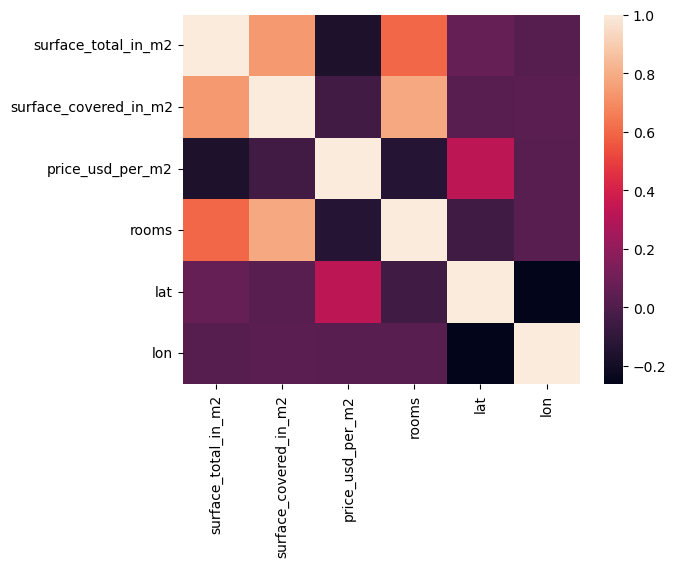

In [27]:
#Multicollinearity Heatmap
corr = df.select_dtypes("number").drop(columns = "price_aprox_usd").corr()
#visualize
sns.heatmap(corr);

In [47]:
# Drop columns with multicollinearity
df.drop(columns = ["surface_total_in_m2", "rooms"], inplace = True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


## Split


In [48]:
#Create target and feature matrix
features = ["surface_covered_in_m2","lat","lon","neighborhood"]
X_train = df[features]

target = "price_aprox_usd"
y_train = df[target]

## Build Model

### Baseline

In [51]:
y_mean = y_train.mean()

y_pred_baseline = [y_mean] * len(y_train)
len(y_pred_baseline) == len(y_train)

True

In [52]:
# Mean absolute error baseline
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:", round(baseline_mae,2))

Mean apt price: 132383.84
Baseline MAE: 44860.11


## Iterate

In [53]:
# Create a pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [57]:
# Training MAE
y_pred_training = model.predict(X_train)

print("Training MAE:", round(mean_absolute_error(y_train,y_pred_training),2))

Training MAE: 24207.11


In [70]:
#Import test data into a data frame 
X_test = pd.read_csv("data/buenos-aires-test-features.csv", encoding = "latin-1")
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]

#Generate a list of predictions using the model
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

## Communicate Results

In [77]:
#Prediction function
def make_prediction(area,lat,lon,neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood  
    }

    df= pd.DataFrame(data, index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"predicted apartment Price : {prediction}"
    

### Sample data example to see if our function works

In [78]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'predicted apartment Price : 250775.11'

### Interactive Dashboard

In [79]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

**Here a user can select a neighborhood and then supply latitude-longitude coordinates that aren't in that neighborhood to get the predicted price of an apartment .**